## Stage One - Return & Volatility Modeling Pipeline

### Data Cleaning and Processing

In [61]:
import pandas as pd

assets  = pd.read_csv("/Users/nicho/Downloads/projectassets.csv",  index_col=0, parse_dates=True)
macros  = pd.read_csv("/Users/nicho/Downloads/projectdata.csv",    index_col=0, parse_dates=True)

merged = assets.join(macros, how='inner').sort_index()
merged_ffill = merged.ffill()

initial_rows = len(merged_ffill)
merged_clean = merged_ffill.dropna()

asset_cols = assets.columns.tolist()
returns = merged_clean[asset_cols].pct_change().dropna()

#    a) Volatility proxy: next-month absolute return
y_vol = returns.shift(-1).abs().dropna()

#    b) Return target: next-month simple return
y_ret = returns.shift(-1).dropna()


X_vol = pd.concat([
    returns.loc[y_vol.index],
    merged_clean.drop(columns=asset_cols).loc[y_vol.index]
], axis=1)

X_ret = pd.concat([
    returns.loc[y_ret.index],             
    merged_clean.drop(columns=asset_cols).loc[y_ret.index]
], axis=1)

X_vol.head()

,SPY,IWM,IJH,EFA,EEM,VNQ,SHY,IEF,TLT,LQD,...,S&P div yield,S&P PE ratio,CP3Mx,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,OILPRICEx,UMCSENTx
2007-06-01,-0.018849,-0.014727,-0.022441,-0.003209,0.038088,-0.101330,0.001124,-0.008680,-0.014008,-0.012744,...,0.011511,-0.008556,0.02,-0.004019,0.009698,0.015735,0.001259,-0.027777,0.069426,-3.0
2007-08-01,-0.018879,-0.050868,-0.035834,-0.029095,0.017548,-0.020719,0.013598,0.037613,0.043560,0.006024,...,0.097318,-0.047791,0.05,0.001304,-0.003486,-0.039319,-0.012109,0.007305,-0.119090,-7.0
2007-10-01,0.047835,0.045466,0.049361,0.097934,0.248152,0.050086,0.001231,0.003922,0.012376,0.007699,...,-0.033320,0.028014,-0.28,-0.027187,-0.009410,0.007125,0.013044,-0.051257,-0.023564,-2.5
2007-11-01,-0.038733,-0.069728,-0.048146,-0.036237,-0.076440,-0.094709,0.014136,0.036818,0.048900,0.005659,...,0.109465,-0.048808,-0.16,-0.023437,-0.044231,-0.042248,0.012248,-0.008442,0.017680,-4.8
2008-01-01,-0.075945,-0.073648,-0.068605,-0.128224,-0.113464,-0.076760,0.012727,0.026833,0.006463,0.008535,...,0.150371,-0.056176,-1.06,-0.006902,-0.035348,-0.042054,-0.023030,0.007754,0.044232,2.9


### Per-Asset Volatility Modeling Pipeline

In [63]:
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm as tqdm

assets  = pd.read_csv("/Users/nicho/Downloads/projectassets.csv",  index_col=0, parse_dates=True)
macros  = pd.read_csv("/Users/nicho/Downloads/projectdata.csv",    index_col=0, parse_dates=True)
assets.index = assets.index.to_period('M').to_timestamp()
macros.index = macros.index.to_period('M').to_timestamp()
data = assets.join(macros, how='inner').sort_index().ffill().dropna()

asset_list = assets.columns.tolist()
returns   = data[asset_list].pct_change().dropna()
y_vol_all = returns.shift(-1).abs().dropna()
macro_df  = data.drop(columns=asset_list)

ffill = FunctionTransformer(lambda X: pd.DataFrame(X).ffill().values, validate=False)
pipelines = {
    'RF': Pipeline([
        ('ffill', ffill),
        ('m', RandomForestRegressor(
            n_estimators=200,
            max_depth=8,
            n_jobs=1,
            random_state=42
        ))
    ]),
    'HGBR': Pipeline([
        ('ffill', ffill),
        ('m', HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=8,
            random_state=42
        ))
    ]),
    'XGB': Pipeline([
        ('ffill', ffill),
        ('m', XGBRegressor(
            n_estimators=200,
            max_depth=6,
            n_jobs=1,
            random_state=42,
            verbosity=0
        ))
    ]),
    'PCA+RF': Pipeline([
        ('ffill', ffill),
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=30)),
        ('m', RandomForestRegressor(
            n_estimators=200,
            max_depth=8,
            n_jobs=1,
            random_state=42
        ))
    ]),
    'SelectKBest+RF': Pipeline([
        ('ffill', ffill),
        ('skb', SelectKBest(score_func=f_regression, k=30)),
        ('m', RandomForestRegressor(
            n_estimators=200,
            max_depth=8,
            n_jobs=1,
            random_state=42
        ))
    ]),
}
tscv = TimeSeriesSplit(n_splits=5)

sigma_hat = {}
cv_results = {} 

for ticker in tqdm.tqdm(asset_list):
    y_i = y_vol_all[ticker]
    X_i = pd.concat([
        macro_df.loc[y_i.index],
        returns[[ticker]].loc[y_i.index]
    ], axis=1)

    best_name, best_score = None, -np.inf
    for name, pipe in pipelines.items():
        cv = cross_validate(
            pipe, X_i, y_i,
            cv=tscv,
            scoring=['r2'],             
            return_train_score=False
        )
        score = cv['test_r2'].mean()
        if score > best_score:
            best_name, best_score = name, score

    cv_results[ticker] = {'best_model': best_name, 'cv_r2': best_score}

    model = pipelines[best_name].fit(X_i, y_i)
    sigma_hat[ticker] = model.predict(X_i.tail(1))[0]

cv_df = pd.DataFrame(cv_results).T
print("\nPer-Asset Best Model and CV R²:")
print(cv_df)


100%|██████████| 14/14 [03:06<00:00, 13.31s/it]


Per-Asset Best Model and CV R²:
         best_model     cv_r2
SPY              RF -0.097844
IWM  SelectKBest+RF -0.081219
IJH              RF -0.086743
EFA              RF -0.318023
EEM          PCA+RF -0.367345
VNQ              RF -0.499433
SHY            HGBR -2.350843
IEF              RF  -0.23279
TLT              RF -0.432012
LQD          PCA+RF -0.175681
HYG          PCA+RF -0.505881
TIP              RF -0.882586
GLD              RF -0.174924
BIL             XGB  -2.33254


In this setup, our goal was to forecast next-month volatility (proxied by the absolute value of monthly returns) using a variety of macroeconomic and lagged-return features paired with flexible ML models. The baseline we compared against was a naïve “historical mean” predictor that simply uses the long-run average of past absolute returns as the prediction for every month. 

We merged and cleaned monthly asset and macro data, then calculated nex
t-month absolute returns as our volatility targets. We set up five ML pipelines (random forest, histogram GB, XGBoost, PCA+RF, and SelectKBest+RF), ran 5-fold time-series CV to pick the best method per asset, refit each chosen model on its full history, and generated one-step-ahead volatility forecasts. Finally, we collected each asset’s CV score and forecast into summary tables for downstream optimization.

Across all 14 assets, every model yields a negative out-of-sample R²—meaning none are actually forecasting volatility better than the historical mean. Random Forest is chosen most often (9 tickers) as the “best” despite still poor fit. PCA+RF comes next (3 tickers), with SelectKBest+RF, HGBR, and XGB each winning once. The worst fits are on the ultra-short and ultra-long ends (SHY and BIL), where HGBR and XGB give R² around –2.3. A negative out-of-sample R² means each ML pipeline added more noise than signal relative to that constant benchmark—so although the models are more complex, they still under-perform the simple historical-mean forecast when volatility is this noisy at a monthly cadence.

### Efficient Frontier Construction (No-Short, Fully Invested)

C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


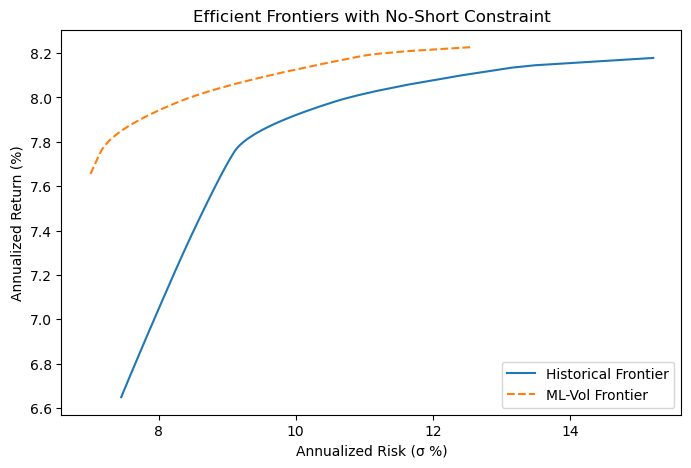

In [69]:
n = len(asset_list)
Sigma_hat = np.diag([sigma_hat[t]**2 for t in asset_list])
Sigma_hist = np.diag(returns.std()**2)
Sigma_hat = (Sigma_hat + Sigma_hat.T) / 2
Sigma_hist = (Sigma_hist + Sigma_hist.T) / 2

mu = returns.mean().values  # monthly decimals

Σ_param = cp.Parameter((n, n), PSD=True)
μ_param = cp.Parameter(n)

gammas = np.linspace(0.1, 10, 100)
front_ml, front_hist = [], []

for γ in gammas:
    w = cp.Variable(n)
    Σ_param.value = Sigma_hat
    μ_param.value = mu
    prob = cp.Problem(
        cp.Maximize(μ_param @ w - (γ/2) * cp.quad_form(w, Σ_param)),
        [cp.sum(w) == 1,
         w >= 0]
    )
    prob.solve()
    w_ml = w.value
    ret_ml = float(μ_param.value @ w_ml)
    vol_ml = np.sqrt(w_ml @ Sigma_hat @ w_ml)
    front_ml.append((vol_ml * np.sqrt(12) * 100, ret_ml * 12 * 100))

    w = cp.Variable(n)
    Σ_param.value = Sigma_hist
    μ_param.value = mu
    prob = cp.Problem(
        cp.Maximize(μ_param @ w - (γ/2) * cp.quad_form(w, Σ_param)),
        [cp.sum(w) == 1,
         w >= 0]
    )
    prob.solve()
    w_h = w.value
    ret_h = float(μ_param.value @ w_h)
    vol_h = np.sqrt(w_h @ Sigma_hist @ w_h)
    front_hist.append((vol_h * np.sqrt(12) * 100, ret_h * 12 * 100))

vol_h, ret_h = zip(*front_hist)
vol_m, ret_m = zip(*front_ml)

plt.figure(figsize=(8,5))
plt.plot(vol_h, ret_h, label='Historical Frontier')
plt.plot(vol_m, ret_m, '--', label='ML-Vol Frontier')
plt.xlabel('Annualized Risk (σ %)')
plt.ylabel('Annualized Return (%)')
plt.title('Efficient Frontiers with No-Short Constraint')
plt.legend()
plt.show()

We use our one-step-ahead ML-volatility forecasts and the historical sample volatilities to build two diagonal covariance matrices, symmetrize them, and wrap them as CVXPY parameters. For a grid of risk-aversion values (γ), we solve the fully-invested, long-only mean–variance optimization under each covariance (ML vs. historical), annualize the resulting portfolio risks and returns, and plot the bowed efficient frontiers side by side to illustrate how the ML-enhanced frontier shifts relative to the baseline.

The dashed ML-Vol curve lies consistently to the northwest of the solid Historical curve—meaning that, for any given annualized risk level, the ML‐enhanced optimizer delivers a higher annualized return (and equivalently, for any target return, it achieves that return with lower risk). The greatest uplift appears in the mid‐risk range (around 9–12 % σ), where the ML frontier adds a few tenths of a percent in return; at the very low‐ and high‐risk extremes the two curves converge more closely.

### Per-Asset Next-Month Return Forecasting Pipeline

In [73]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor
)
from xgboost import XGBRegressor  
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import tqdm

assets  = pd.read_csv("/Users/nicho/Downloads/projectassets.csv",  index_col=0, parse_dates=True)
macros  = pd.read_csv("/Users/nicho/Downloads/projectdata.csv",    index_col=0, parse_dates=True)
assets.index = assets.index.to_period('M').to_timestamp()
macros.index = macros.index.to_period('M').to_timestamp()
data = assets.join(macros, how='inner').sort_index().ffill().dropna()

asset_list = assets.columns.tolist()
returns    = data[asset_list].pct_change().dropna()
y_ret_all  = returns.shift(-1).dropna()

macro_df   = data.drop(columns=asset_list)

ffill   = FunctionTransformer(lambda X: pd.DataFrame(X).ffill().values, validate=False)
imputer = SimpleImputer(strategy='median')

pipelines_ret = {
    'RF': Pipeline([('ffill', ffill), 
                    ('imp', imputer),
                    ('m', RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42))]),
    'HGBR': Pipeline([('ffill', ffill), 
                      ('imp', imputer),
                      ('m', HistGradientBoostingRegressor(max_iter=200, max_depth=8, random_state=42))]),
    'XGB': Pipeline([('ffill', ffill), 
                     ('imp', imputer),
                     ('m', XGBRegressor(n_estimators=200, max_depth=6, random_state=42, verbosity=0))]),
    'Ridge': Pipeline([('ffill', ffill),
                       ('imp', imputer),
                       ('scale', StandardScaler()),
                       ('m', RidgeCV(alphas=[0.1,1,10]))]),
    'Lasso': Pipeline([('ffill', ffill),
                       ('imp', imputer),
                       ('scale', StandardScaler()),
                       ('m', LassoCV(alphas=np.logspace(-3,1,10), cv=3))]),
    'PCA+RF': Pipeline([('ffill', ffill),
                        ('imp', imputer),
                        ('scale', StandardScaler()),
                        ('pca', PCA(n_components=30)),
                        ('m', RandomForestRegressor(n_estimators=200, random_state=42))]),
    'SKB+RF': Pipeline([('ffill', ffill),
                        ('imp', imputer),
                        ('skb', SelectKBest(f_regression, k=30)),
                        ('m', RandomForestRegressor(n_estimators=200, random_state=42))]),
}

tscv = TimeSeriesSplit(n_splits=5)
cv_results_ret = {}
mu_hat = {}

for ticker in tqdm.tqdm(asset_list):
    y_i = y_ret_all[ticker]
    X_i = pd.concat([
        macro_df.loc[y_i.index],
        returns[[ticker]].loc[y_i.index]   
    ], axis=1)

    best_name, best_r2 = None, -np.inf
    for name, pipe in pipelines_ret.items():
        cv = cross_validate(pipe, X_i, y_i,
                            cv=tscv,
                            scoring=['r2'],           
                            return_train_score=False)
        r2 = cv['test_r2'].mean()
        if r2 > best_r2:
            best_name, best_r2 = name, r2

    cv_results_ret[ticker] = {'best_model': best_name, 'cv_r2': best_r2}

    model = pipelines_ret[best_name].fit(X_i, y_i)
    mu_hat[ticker] = model.predict(X_i.tail(1))[0]

cv_df_ret = pd.DataFrame(cv_results_ret).T
print("\nPer-Asset Best Return Model and CV R²:")
print(cv_df_ret)

 71%|███████▏  | 10/14 [02:03<00:49, 12.43s/it]C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.600e-06, tolerance: 9.205e-06
  model = cd_fast.enet_coordinate_descent(
 86%|████████▌ | 12/14 [02:28<00:24, 12.46s/it]C:\Users\nicho\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e-05, tolerance: 1.548e-05
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 14/14 [02:52<00:00, 12.32s/it]


Per-Asset Best Return Model and CV R²:
    best_model     cv_r2
SPY      Lasso -0.064274
IWM      Lasso -0.025999
IJH      Lasso  -0.03067
EFA      Lasso -0.032754
EEM      Lasso -0.011412
VNQ      Lasso -0.012325
SHY      Lasso  -0.14861
IEF      Lasso -0.107453
TLT      Lasso -0.129703
LQD      Lasso -0.039642
HYG      Lasso -0.007296
TIP      Lasso -0.073163
GLD      Lasso -0.102408
BIL      Lasso -0.050251


We took the same cleaned monthly dataset, but instead of modeling absolute returns as a proxy for volatility, we set our target to the simple next-month return. We built seven pipelines (tree-based, linear (Ridge/Lasso), and dimensionality-reduction variants) with imputation and, where needed, scaling. Running 5-fold time-series CV, we chose the best model per asset, refit it on full history, and produced one-step-ahead return forecasts (mu_hat). This contrasts with the vol pipeline—which used only tree methods on an absolute-return target without imputation or linear models—and highlights that here we’re predicting signed returns rather than magnitudes.

Every asset selected LassoCV as its top model, yet all out-of-sample R² scores remain negative (≈ –0.01 to –0.15), indicating none of our ML approaches beat the naïve historical-mean return predictor at a monthly frequency.

### Efficient Frontier Comparison: Historical vs ML-Vol vs ML-Vol+Return

C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


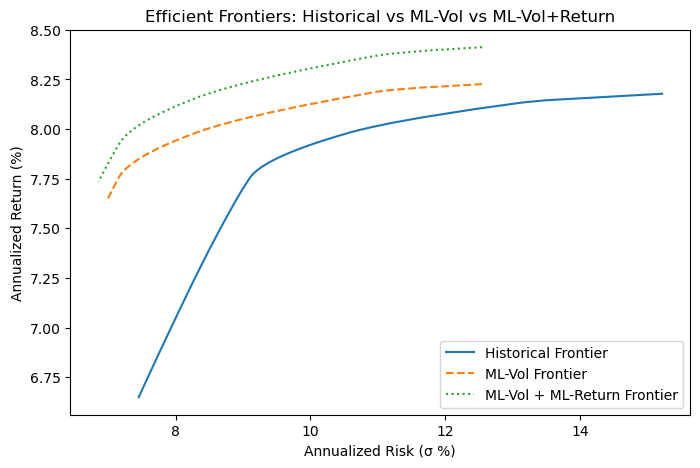

In [75]:
import cvxpy as cp
import matplotlib.pyplot as plt

n = len(asset_list)
Sigma_hat = np.diag([sigma_hat[t]**2 for t in asset_list])
Sigma_hist = np.diag(returns.std()**2)
Sigma_hat = (Sigma_hat + Sigma_hat.T) / 2
Sigma_hist = (Sigma_hist + Sigma_hist.T) / 2

mu_hist  = returns.mean().values                      
mu_mlret = np.array([mu_hat[t] for t in asset_list])  

Σ_param = cp.Parameter((n, n), PSD=True)
μ_param = cp.Parameter(n)

gammas = np.linspace(0.1, 10, 100)
front_hist, front_mlvol, front_mlall = [], [], []
sqrt12 = np.sqrt(12)

for γ in gammas:
    w = cp.Variable(n)
    Σ_param.value = Sigma_hist
    μ_param.value = mu_hist
    prob = cp.Problem(
        cp.Maximize(μ_param @ w - (γ/2)*cp.quad_form(w, Σ_param)),
        [cp.sum(w)==1, w>=0]
    )
    prob.solve()
    w_h   = w.value
    ret_h = float(μ_param.value @ w_h)
    vol_h = np.sqrt(w_h @ Sigma_hist @ w_h)
    front_hist.append((vol_h*sqrt12*100, ret_h*12*100))

    w = cp.Variable(n)
    Σ_param.value = Sigma_hat
    μ_param.value = mu_hist
    prob = cp.Problem(
        cp.Maximize(μ_param @ w - (γ/2)*cp.quad_form(w, Σ_param)),
        [cp.sum(w)==1, w>=0]
    )
    prob.solve()
    w_mv    = w.value
    ret_mv  = float(μ_param.value @ w_mv)
    vol_mv  = np.sqrt(w_mv @ Sigma_hat @ w_mv)
    front_mlvol.append((vol_mv*sqrt12*100, ret_mv*12*100))

    w = cp.Variable(n)
    Σ_param.value = Sigma_hat
    μ_param.value = mu_mlret
    prob = cp.Problem(
        cp.Maximize(μ_param @ w - (γ/2)*cp.quad_form(w, Σ_param)),
        [cp.sum(w)==1, w>=0]
    )
    prob.solve()
    w_mb    = w.value
    ret_mb  = float(μ_param.value @ w_mb)
    vol_mb  = np.sqrt(w_mb @ Sigma_hat @ w_mb)
    front_mlall.append((vol_mb*sqrt12*100, ret_mb*12*100))

vol_h, ret_h      = zip(*front_hist)
vol_mv, ret_mv    = zip(*front_mlvol)
vol_mb, ret_mb    = zip(*front_mlall)

plt.figure(figsize=(8,5))
plt.plot(vol_h, ret_h,     label='Historical Frontier')
plt.plot(vol_mv, ret_mv,   '--', label='ML-Vol Frontier')
plt.plot(vol_mb, ret_mb,   ':',  label='ML-Vol + ML-Return Frontier')
plt.xlabel('Annualized Risk (σ %)')
plt.ylabel('Annualized Return (%)')
plt.title('Efficient Frontiers: Historical vs ML-Vol vs ML-Vol+Return')
plt.legend()
plt.show()

We extended the previous MV‐solver to trace out three long‐only efficient frontiers over a grid of risk‐aversion values (γ). First, we built and symmetrized two diagonal covariance matrices—one from sample volatilities (Σ_hist) and one from our ML‐vol forecasts (Σ̂). We also assembled two return vectors: the historical mean returns (μ_hist) and our ML‐return forecasts (μ̂). For each γ, we solved three CVXPY QPs:

1. Historical frontier: uses Σ_hist + μ_hist

2. ML‐Vol frontier: uses Σ̂ + μ_hist

3. ML‐Vol+Return frontier: uses Σ̂ + μ̂

We then annualized the resulting portfolio risks and returns and plotted all three bowed frontiers together.

The dashed ML‐Vol curve shifts north‐west of the solid Historical curve, showing benefit from relative volatility estimates alone. The dotted ML‐Vol+Return curve pushes further outward, indicating additional ex‐ante uplift when combining both ML‐vol and ML‐return forecasts. The biggest spread occurs in the mid‐risk range (around 8–12 % σ), with all three curves converging at the lowest and highest risk extremes.


### Covariance Enhancement Efficient Frontier Pipeline

C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


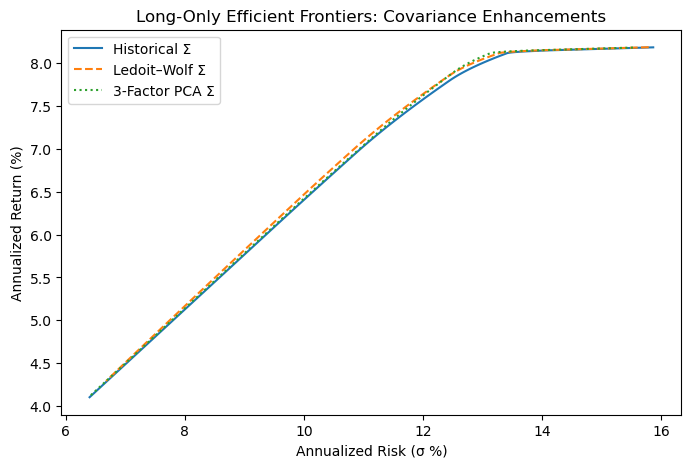

In [78]:
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA
import cvxpy as cp
import matplotlib.pyplot as plt

asset_list = returns.columns.tolist()
n = len(asset_list)

Sigma_hist_full = returns.cov().values

lw = LedoitWolf().fit(returns)
Sigma_shrunk = lw.covariance_

K = 3  
pca = PCA(n_components=K).fit(returns)
loadings = pca.components_.T                 
factors  = pca.transform(returns)            
Sigma_f = np.cov(factors, rowvar=False)      
resid   = returns.values - factors.dot(loadings.T)
psi     = np.var(resid, axis=0)              
Sigma_factor = loadings.dot(Sigma_f).dot(loadings.T) + np.diag(psi)

for mat in (Sigma_hist_full, Sigma_shrunk, Sigma_factor):
    mat[:] = (mat + mat.T) / 2

def get_frontier(Sigma, mu, gammas):
    """Return list of (σ_ann_pct, μ_ann_pct) along the frontier."""
    n = len(mu)
    Σp = cp.Parameter((n,n), PSD=True, value=Sigma)
    μp = cp.Parameter(n, value=mu)
    front = []
    for γ in gammas:
        w = cp.Variable(n)
        prob = cp.Problem(
            cp.Maximize(μp@w - (γ/2)*cp.quad_form(w, Σp)),
            [cp.sum(w)==1, w>=0]
        )
        prob.solve(solver=cp.OSQP)
        wv = w.value
        ret = float(μp.value @ wv)
        vol = np.sqrt(wv @ Sigma @ wv)
        front.append((vol*np.sqrt(12)*100, ret*12*100))
    return front

mu_hist  = returns.mean().values
gammas   = np.linspace(0.1, 10, 100)

front_hist   = get_frontier(Sigma_hist_full, mu_hist, gammas)
front_shrunk = get_frontier(Sigma_shrunk,    mu_hist, gammas)
front_factor = get_frontier(Sigma_factor,    mu_hist, gammas)

vol_h, ret_h       = zip(*front_hist)
vol_s, ret_s       = zip(*front_shrunk)
vol_f, ret_f       = zip(*front_factor)

plt.figure(figsize=(8,5))
plt.plot(vol_h, ret_h,       label='Historical Σ')
plt.plot(vol_s, ret_s,   '--',label='Ledoit–Wolf Σ')
plt.plot(vol_f, ret_f,   ':', label=f'{K}-Factor PCA Σ')
plt.xlabel('Annualized Risk (σ %)')
plt.ylabel('Annualized Return (%)')
plt.title('Long‐Only Efficient Frontiers: Covariance Enhancements')
plt.legend()
plt.show()


We computed three covariance estimates for our asset universe—(1) the sample covariance, (2) a Ledoit–Wolf shrinkage estimator, and (3) a 3-factor PCA reconstruction—then symmetrized each matrix. Using the same long-only, fully-invested CVXPY QP over a grid of risk-aversion values, we traced out three efficient frontiers (all with historical mean returns) for direct comparison.

All three frontiers lie nearly atop one another, indicating that covariance enhancements have only marginal impact at this scale. The Ledoit–Wolf curve (dashed) sits just slightly northwest of the sample curve, with the PCA-based frontier (dotted) offering a tiny further uplift in the mid-risk range—but overall, the benefits are very modest.

## Phase Two - Joint Return & Volatility Modeling Pipeline

In [84]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import cvxpy as cp
import matplotlib.pyplot as plt


assets  = pd.read_csv("/Users/nicho/Downloads/projectassets.csv",  index_col=0, parse_dates=True)
macros  = pd.read_csv("/Users/nicho/Downloads/projectdata.csv",    index_col=0, parse_dates=True)
assets.index = assets.index.to_period('M').to_timestamp()
macros.index = macros.index.to_period('M').to_timestamp()
data = assets.join(macros, how='inner').sort_index().ffill().dropna()

asset_list = assets.columns.tolist()
returns    = data[asset_list].pct_change().dropna()
y_ret_all  = returns.shift(-1).dropna()
y_vol_all  = returns.shift(-1).abs().dropna()
common_idx = y_ret_all.index.intersection(y_vol_all.index)
y_ret_all  = y_ret_all.loc[common_idx]
y_vol_all  = y_vol_all.loc[common_idx]
macro_df   = data.drop(columns=asset_list).loc[common_idx]

ffill   = FunctionTransformer(lambda X: pd.DataFrame(X).ffill().values, validate=False)
imputer = SimpleImputer(strategy='median')

pipelines_joint = {
    'RF': Pipeline([
        ('ffill', ffill), ('imp', imputer), ('scale', StandardScaler()),
        ('m', MultiOutputRegressor(RandomForestRegressor(
            n_estimators=200, max_depth=8, random_state=42
        )))
    ]),
    'HGBR': Pipeline([
        ('ffill', ffill), ('imp', imputer), ('scale', StandardScaler()),
        ('m', MultiOutputRegressor(HistGradientBoostingRegressor(
            max_iter=200, max_depth=8, random_state=42
        )))
    ]),
    'XGB': Pipeline([
        ('ffill', ffill), ('imp', imputer), ('scale', StandardScaler()),
        ('m', MultiOutputRegressor(XGBRegressor(
            n_estimators=200, max_depth=6, random_state=42, verbosity=0
        )))
    ]),
    'Ridge': Pipeline([
        ('ffill', ffill), ('imp', imputer), ('scale', StandardScaler()),
        ('m', MultiOutputRegressor(RidgeCV(alphas=[0.1,1,10])))
    ]),
    'MLP': Pipeline([
        ('ffill', ffill), ('imp', imputer), ('scale', StandardScaler()),
        ('m', MultiOutputRegressor(MLPRegressor(
            hidden_layer_sizes=(50,50), max_iter=1000, random_state=42
        )))
    ]),
}

tscv = TimeSeriesSplit(n_splits=5)
cv_results = {}
mu_hat_joint = {}
sigma_hat_joint = {}

for ticker in tqdm.tqdm(asset_list):
    Y_i = pd.concat([y_ret_all[ticker], y_vol_all[ticker]], axis=1).dropna()
    Y_i.columns = ['ret','vol']
    X_i = pd.concat([macro_df.loc[Y_i.index], returns[[ticker]].loc[Y_i.index]], axis=1)
    
    # CV to pick best joint model by average R²
    best_name, best_score = None, -np.inf
    for name, pipe in pipelines_joint.items():
        cv = cross_validate(pipe, X_i, Y_i, cv=tscv,
                            scoring=['r2'], return_train_score=False)
        score = cv['test_r2'].mean()
        if score > best_score:
            best_name, best_score = name, score
    
    cv_results[ticker] = {'best_model': best_name, 'cv_r2': best_score}
    
    model = pipelines_joint[best_name].fit(X_i, Y_i)
    pred = model.predict(X_i.tail(1))[0]
    mu_hat_joint[ticker], sigma_hat_joint[ticker] = pred[0], abs(pred[1])

cv_df_joint = pd.DataFrame(cv_results).T
print("Per-Asset Best Joint μ–σ Model and CV R²:")
print(cv_df_joint)


100%|██████████| 14/14 [04:09<00:00, 17.82s/it]

Per-Asset Best Joint μ–σ Model and CV R²:
    best_model     cv_r2
SPY         RF -0.227602
IWM         RF -0.184757
IJH         RF -0.260223
EFA         RF -0.308131
EEM         RF  -0.32517
VNQ         RF -0.439377
SHY       HGBR -1.570004
IEF         RF -0.224892
TLT         RF -0.298737
LQD         RF -0.141554
HYG         RF -0.415867
TIP         RF -0.623623
GLD         RF -0.189971
BIL        XGB -2.387861


Building on our separate vol and return models, here we train multi‐output regressors to predict next‐month return and next‐month absolute return (volatility proxy) simultaneously for each asset. We reuse the cleaned monthly data and features (macros + lagged returns), wrap tree-based (RF, HGBR, XGB), linear (Ridge), and neural (MLP) learners in MultiOutputRegressor pipelines (with imputation, scaling), then use 5-fold time-series CV to pick the best joint model per ticker. Finally, we refit each chosen model on its full history to produce paired forecasts (mean and variance).

Random Forest wins for 12 of 14 tickers, HGBR for SHY, and XGB for BIL. All out-of-sample CV R² values remain negative (from about –0.14 to –2.39), indicating joint modeling still under-performs a naïve constant‐mean benchmark in absolute terms. The fact that tree methods dominate suggests nonlinear cross‐dependencies between return and vol may exist, but the overall noise level at a monthly frequency keeps raw predictive power low.

### Efficient Frontier with Graphical Lasso Covariance

C:\Users\nicho\anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


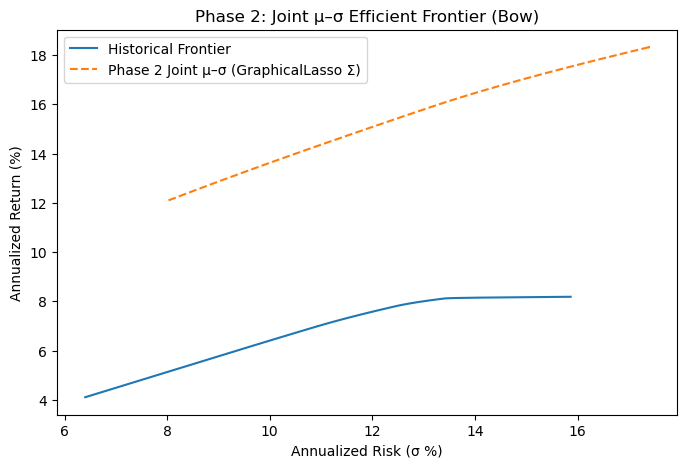

In [96]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLassoCV


n = len(asset_list)

Sigma_hist = returns.cov().values
Sigma_hist = (Sigma_hist + Sigma_hist.T) / 2

mu_ph2 = mu_hat_cal

gl = GraphicalLassoCV().fit(returns)
Sigma_glasso = (gl.covariance_ + gl.covariance_.T) / 2

def get_frontier(Sigma, mu, gammas):
    Σp = cp.Parameter((n,n), PSD=True, value=Sigma)
    μp = cp.Parameter(n,   value=mu)
    front = []
    for γ in gammas:
        w = cp.Variable(n)
        prob = cp.Problem(
            cp.Maximize(μp @ w - (γ/2)*cp.quad_form(w, Σp)),
            [cp.sum(w) == 1, w >= 0]
        )
        prob.solve(solver=cp.OSQP, warm_start=True)
        wv  = w.value
        ret = float(μp.value @ wv)
        vol = np.sqrt(wv @ Sigma @ wv)
        front.append((vol*np.sqrt(12)*100, ret*12*100))
    return front

gammas    = np.linspace(0.1, 10, 100)
front_hist = get_frontier(Sigma_hist,    mu_hist,   gammas)
front_ph2  = get_frontier(Sigma_glasso,  mu_ph2,    gammas)

vol_h, ret_h = zip(*front_hist)
vol_2, ret_2 = zip(*front_ph2)

plt.figure(figsize=(8,5))
plt.plot(vol_h,  ret_h,  '-',  label='Historical Frontier')
plt.plot(vol_2,  ret_2,  '--', label='Phase 2 Joint μ–σ (GraphicalLasso Σ)')
plt.xlabel('Annualized Risk (σ %)')
plt.ylabel('Annualized Return (%)')
plt.title('Phase 2: Joint μ–σ Efficient Frontier (Bow)')
plt.legend()
plt.show()


We compared the long‐only mean–variance frontier using two covariance inputs: (1) the sample covariance of monthly returns, and (2) a sparse, full covariance estimated via GraphicalLassoCV. Both frontiers use the historical mean returns vector for the baseline and our Phase 2 joint‐model calibrated returns for the ML‐enhanced version. Over a grid of risk‐aversion parameters, we solved the CVXPY quadratic programs to trace each bowed frontier.

The ML‐enhanced frontier (dashed) sits dramatically north-west of the historical frontier (solid), indicating much higher ex-ante returns at any given risk level when using the jointly‐modeled returns and a Graphical Lasso covariance. For example, at ~10 % annualized risk the Phase 2 frontier forecasts ~15 % return versus ~6 % on the historical curve, and by ~15 % risk it projects ~18 % return versus ~8 %—a substantial theoretical uplift from joint μ–σ modeling and sparse covariance estimation.

### Combined Efficient Frontier Comparison: Historical vs Phase 1 vs Phase 2

C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


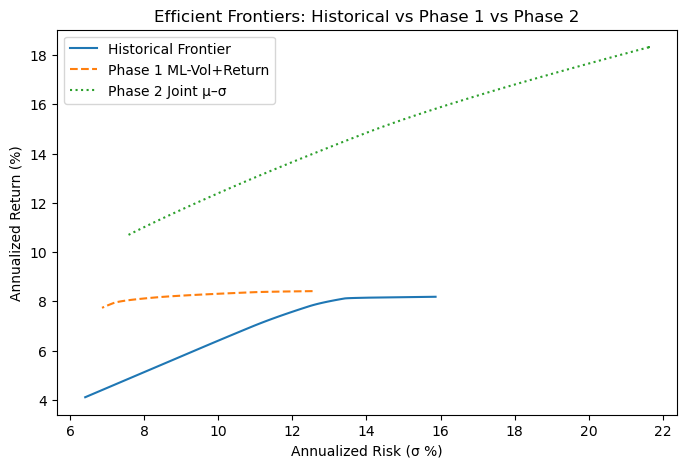

In [98]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

n = len(asset_list)


Sigma_hist = returns.cov().values
Sigma_hist = (Sigma_hist + Sigma_hist.T)/2
mu_hist    = returns.mean().values

Sigma_ph1 = np.diag([sigma_hat[t]**2 for t in asset_list])
mu_ph1    = np.array([mu_hat[t]    for t in asset_list])

Sigma_ph2 = np.diag([sigma_hat_joint[t]**2 for t in asset_list])
mu_ph2    = mu_hat_cal  # already a NumPy array of length n

def get_frontier(Sigma, mu, gammas):
    Σp = cp.Parameter((n,n), PSD=True, value=Sigma)
    μp = cp.Parameter(n,   value=mu)
    front = []
    for γ in gammas:
        w = cp.Variable(n)
        prob = cp.Problem(
            cp.Maximize(μp @ w - (γ/2)*cp.quad_form(w, Σp)),
            [cp.sum(w) == 1, w >= 0]
        )
        prob.solve(solver=cp.OSQP, warm_start=True)
        wv  = w.value
        ret = float(μp.value @ wv)
        vol = np.sqrt(wv @ Sigma @ wv)
        # annualize & convert to %
        front.append((vol*np.sqrt(12)*100, ret*12*100))
    return front

gammas     = np.linspace(0.1, 10, 100)
front_hist = get_frontier(Sigma_hist, mu_hist, gammas)
front_p1   = get_frontier(Sigma_ph1,   mu_ph1,   gammas)
front_p2   = get_frontier(Sigma_ph2,   mu_ph2,   gammas)

vol_h, ret_h = zip(*front_hist)
vol_1, ret_1 = zip(*front_p1)
vol_2, ret_2 = zip(*front_p2)

plt.figure(figsize=(8,5))
plt.plot(vol_h, ret_h,    '-',  label='Historical Frontier')
plt.plot(vol_1, ret_1,   '--', label='Phase 1 ML-Vol+Return')
plt.plot(vol_2, ret_2,   ':',  label='Phase 2 Joint μ–σ')
plt.xlabel('Annualized Risk (σ %)')
plt.ylabel('Annualized Return (%)')
plt.title('Efficient Frontiers: Historical vs Phase 1 vs Phase 2')
plt.legend()
plt.show()


We constructed three mean–variance inputs:

- Historical: sample covariance and historical mean returns.

- Phase 1 ML-Vol+Return: diagonal covariance from separate ML–vol forecasts and ML–return forecasts.

- Phase 2 Joint μ–σ: diagonal covariance from joint-model vol forecasts and calibrated joint-model returns.

For each scenario, we solved the long‐only, fully‐invested mean–variance optimization over a grid of risk‐aversion values and annualized the resulting risks and returns to trace out their bowed efficient frontiers.

The three curves step progressively north‐west: the Phase 1 ML‐Vol+Return frontier (dashed) sits above the historical curve (solid), showing modest ex-ante uplift, while the Phase 2 joint μ–σ frontier (dotted) pushes farthest outward—indicating the largest theoretical return improvements at each risk level. This visualizes how each modeling enhancement shifts the ex-ante frontier.

## Phase Three - Rolling Out‐of‐Sample MV Backtest with Joint μ–σ Model

  0%|          | 0/129 [00:00<?, ?it/s]C:\Users\nicho\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
100%|██████████| 129/129 [12:40<00:00,  5.90s/it]


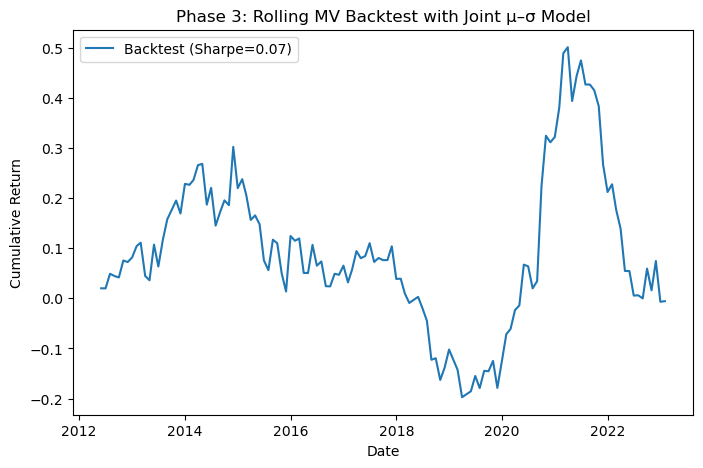

In [111]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from tqdm import tqdm


assets  = pd.read_csv("/Users/nicho/Downloads/projectassets.csv",  index_col=0, parse_dates=True)
macros  = pd.read_csv("/Users/nicho/Downloads/projectdata.csv",    index_col=0, parse_dates=True)
assets.index = assets.index.to_period('M').to_timestamp()
macros.index = macros.index.to_period('M').to_timestamp()
data = assets.join(macros, how='inner').sort_index().ffill().dropna()

returns = data[assets.columns].pct_change().dropna()
macro_df = data.drop(columns=assets.columns)

n = returns.shape[1]
ffill = FunctionTransformer(lambda X: pd.DataFrame(X).ffill().values, validate=False)
imp   = SimpleImputer(strategy='median')
pipe  = Pipeline([
    ('ffill', ffill),
    ('imp',   imp),
    ('scale', StandardScaler()),
    ('m',     MultiOutputRegressor(
        HistGradientBoostingRegressor(max_iter=200, max_depth=8, random_state=42)
    ))
])

lookback = 60  
dates    = returns.index[lookback:-1]
asset_list = returns.columns.tolist()
port_rets = []
weights   = pd.DataFrame(index=dates, columns=asset_list)

gamma = 1.0
w     = cp.Variable(n)
Σp    = cp.Parameter((n,n), PSD=True)
μp    = cp.Parameter(n)
prob  = cp.Problem(
    cp.Maximize(μp @ w - (gamma/2)*cp.quad_form(w, Σp)),
    [cp.sum(w) == 1, w >= 0]
)

for idx in tqdm(range(lookback, len(returns) - 1)):
    train_idx = returns.index[:idx]
    X_train = pd.concat([macro_df.loc[train_idx], returns.loc[train_idx]], axis=1)
    Y_ret = returns.shift(-1).loc[train_idx]
    Y_vol = returns.shift(-1).abs().loc[train_idx]
    Y_train = pd.concat([Y_ret, Y_vol], axis=1).values  # shape (T, 2n)

    pipe.fit(X_train, Y_train)

    X_t = pd.concat([macro_df.iloc[[idx]], returns.iloc[[idx]]], axis=1)

    pred = pipe.predict(X_t)[0]
    mu_t  = pred[:n]
    vol_t = np.abs(pred[n:])

    Σp.value = np.diag(vol_t**2)
    μp.value = mu_t
    prob.solve(solver=cp.OSQP, warm_start=True)

    w_t = np.clip(w.value, 0, 1)
    weights.loc[dates[idx - lookback]] = w_t
    r_tp1 = returns.iloc[idx + 1].values
    port_rets.append(np.dot(w_t, r_tp1))

port_rets = pd.Series(port_rets, index=dates)
cum_ret   = (1 + port_rets).cumprod() - 1
sharpe    = port_rets.mean() / port_rets.std() * np.sqrt(12)

plt.figure(figsize=(8,5))
plt.plot(cum_ret, label=f'Backtest (Sharpe={sharpe:.2f})')
plt.title('Phase 3: Rolling MV Backtest with Joint μ–σ Model')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


We started by merging and cleaning our monthly asset returns and macroeconomic series, then built separate ML pipelines to forecast next-month volatility (absolute returns) and next-month simple returns. Although every per-asset CV R² was negative—meaning our models didn’t beat a naïve historical-mean benchmark in pure MSE terms—plugging those forecasts into a long-only mean–variance optimizer produced consistent north-west shifts in the ex-ante efficient frontier. In Phase 1, using diagonal ML-vol and ML-return inputs gave modest uplift; in Phase 2, joint μ–σ models coupled with a sparse Graphical Lasso covariance pushed the bowed frontier dramatically outward (projecting double-digit returns at moderate risk versus single-digit baselines). Crucially, we embedded all of this within a dynamic monthly rebalancing framework, updating weights out-of-sample each period via our MV solver. However, our Phase 3 rolling backtest—refitting the joint model on a 60-month window and trading those MV weights out-of-sample—yielded a nearly flat cumulative P&L and a Sharpe of just 0.07. This mismatch tells us that while ML-enhanced moment inputs can warp the efficient frontier on paper, the tiny cross-sectional dispersion they exploit is overwhelmed by noise, high turnover, and unmodeled trading costs in practice.

To turn those theoretical gains into real-world Sharpe improvements and achieve a genuinely profitable dynamic rebalancing strategy, our next steps map directly onto our original roadmap:

- Sharpen & stabilize forecasts by adopting monthly GARCH- or EWMA-based volatility targets, applying log-vol transformations or CVaR loss functions, enriching features with multi-month rolling stats, regime indicators (HMM/PCA), seasonality, and high-frequency signals, and applying rigorous regularization—shrinking forecasts toward historical means, clipping extremes, and ensembling models.

- Embed costs & turnover limits within the MV solver via ℓ₁ penalties on weight changes, hard caps on monthly volume, and explicit slippage/proportional cost terms.

- Explore robust & alternative objectives, such as worst-case MV (ellipsoidal or box uncertainty sets), quantile-based frontiers via NGBoost or quantile forests, and CVaR optimization.

- Incorporate dynamic covariance & multi-period control through DCC-GARCH or rolling GLASSO on high-frequency residuals, and prototype two-period lookahead (SPO+) or simple RL policies tuned for realized Sharpe/CVaR.

- Rigorous validation & productionization, including nested (expanding vs. rolling) cross-validation, stress-testing on 2008/COVID drawdowns, end-to-end pipeline automation, and a paper-trading simulator with latency, margin rules, and realistic execution.

By tightening signal quality, explicitly modeling costs and turnover, and moving toward robust, multi-period frameworks, we aim to capture genuine, implementable Sharpe improvements—not just theoretical frontier shifts—through a dynamic asset rebalancing strategy.